[Sebastian Raschka](http://sebastianraschka.com)  

- [Open in IPython nbviewer](http://nbviewer.ipython.org/github/rasbt/pattern_classification/blob/master/python_howtos/scikit_linear_classificationreate=1)  

- [Link to this IPython notebook on Github](http://nbviewer.ipython.org/github/rasbt/pattern_classification/blob/master/machine_learning/scikit-learn/scikit_linear_classification.ipynb)  

- [Link to the GitHub Repository pattern_classification](https://github.com/rasbt/pattern_classification)

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,scikit-learn,matplotlib

Sebastian Raschka 
last updated: 2016-07-16 

CPython 3.5.1
IPython 5.0.0

numpy 1.11.0
scikit-learn 0.17.1
matplotlib 1.5.1


<hr>
I would be happy to hear your comments and suggestions.  
Please feel free to drop me a note via
[twitter](https://twitter.com/rasbt), [email](mailto:bluewoodtree@gmail.com), or [google+](https://plus.google.com/+SebastianRaschka).
<hr>

# An Introduction to simple linear supervised classification using `scikit-learn`

In this introduction I want to give a brief overview of how Python's `scikit-learn` machine learning library can be used for simple linear classification.

<br>
<br>

# Sections

- [About the dataset](#About-the-dataset)
- [Reading in a dataset from a CSV file](#Reading-in-a-dataset-from-a-CSV-file)
- [Visualizing the Wine dataset](#Visualizing-the-Wine-dataset)
- [Splitting into training and test dataset](#Splitting-into-training-and-test-dataset)
- [Feature Scaling](#Feature-Scaling)
- [Introduction to Multiple Discriminant Analysis (MDA)](#MDA)
- [Classification via LDA](#LDA)
- [Stochastic Gradient Descent (SGD) as linear classifier](#SGD)

<br>
<br>

<br>
<br>

## About the dataset

[[back to top]](#Sections)

For the following tutorial, we will be working with the free "Wine" Dataset that is deposited on the UCI machine learning repository  
(http://archive.ics.uci.edu/ml/datasets/Wine).

<br>

<font size="1">
**Reference:**
Forina, M. et al, PARVUS - An Extendible Package for Data
Exploration, Classification and Correlation. Institute of Pharmaceutical
and Food Analysis and Technologies, Via Brigata Salerno, 
16147 Genoa, Italy.</font>

<br>
<br>

The Wine dataset consists of 3 different classes where each row correspond to a particular wine sample.

The class labels (1, 2, 3) are listed in the first column, and the columns 2-14 correspond to the following 13 attributes (features):

1) Alcohol  
2) Malic acid  
3) Ash  
4) Alcalinity of ash    
5) Magnesium  
6) Total phenols  
7) Flavanoids  
8) Nonflavanoid phenols  
9) Proanthocyanins  
10) Color intensity  
11) Hue  
12) OD280/OD315 of diluted wines  
13) Proline     

An excerpt from the wine_data.csv dataset:
    
<pre>1,14.23,1.71,2.43,15.6,127,2.8,3.06,.28,2.29,5.64,1.04,3.92,1065
1,13.2,1.78,2.14,11.2,100,2.65,2.76,.26,1.28,4.38,1.05,3.4,1050
[...]
2,12.37,.94,1.36,10.6,88,1.98,.57,.28,.42,1.95,1.05,1.82,520
2,12.33,1.1,2.28,16,101,2.05,1.09,.63,.41,3.27,1.25,1.67,680
[...]
3,12.86,1.35,2.32,18,122,1.51,1.25,.21,.94,4.1,.76,1.29,630
3,12.88,2.99,2.4,20,104,1.3,1.22,.24,.83,5.4,.74,1.42,530</pre>

<br>
<br>

## Reading in a dataset from a CSV file

[[back to top]](#Sections)

Since it is quite typical to have the input data stored locally, as mentioned above, we will use the [`numpy.loadtxt`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html) function  now to read in the data from the CSV file.  
(alternatively [`np.genfromtxt()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html) could be used in similar way, it provides some additional options)

In [2]:
import numpy as np

# reading in all data into a NumPy array
all_data = np.loadtxt(open("../../data/wine_data.csv","r"),
        delimiter=",", 
        skiprows=0, 
        dtype=np.float64
        )

# load class labels from column 1
y_wine = all_data[:,0]

# conversion of the class labels to integer-type array
y_wine = y_wine.astype(np.int64, copy=False)

# load the 14 features
X_wine = all_data[:,1:]

# printing some general information about the data
print('\ntotal number of samples (rows):', X_wine.shape[0])
print('total number of features (columns):', X_wine.shape[1])

# printing the 1st wine sample
float_formatter = lambda x: '{:.2f}'.format(x)
np.set_printoptions(formatter={'float_kind':float_formatter})
print('\n1st sample (i.e., 1st row):\nClass label: {:d}\n{:}\n'
          .format(int(y_wine[0]), X_wine[0]))

# printing the rel.frequency of the class labels
print('Class label frequencies')
print('Class 1 samples: {:.2%}'.format(list(y_wine).count(1)/y_wine.shape[0]))
print('Class 2 samples: {:.2%}'.format(list(y_wine).count(2)/y_wine.shape[0]))
print('Class 3 samples: {:.2%}'.format(list(y_wine).count(3)/y_wine.shape[0]))


total number of samples (rows): 178
total number of features (columns): 13

1st sample (i.e., 1st row):
Class label: 1
[14.23 1.71 2.43 15.60 127.00 2.80 3.06 0.28 2.29 5.64 1.04 3.92 1065.00]

Class label frequencies
Class 1 samples: 33.15%
Class 2 samples: 39.89%
Class 3 samples: 26.97%


<br>
<br>

## Visualizing the Wine dataset

[[back to top]](#Sections)

There are endless way to visualize datasets for get an initial idea of how the data looks like. The most common ones are probably histograms and scatter plots.

Scatter plots are useful for visualizing features in more than just one dimension, for example to get a feeling for the correlation between particular features.  
Unfortunately, we can't plot all 13 features here at once, since the visual cortex of us humans is limited to a maximum of three dimensions.

Below, we will create an example 2D-Scatter plot from the features "Alcohol content" and "Malic acid content".  
Additionally, we will use the [`scipy.stats.pearsonr`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) function to calculate a Pearson correlation coefficient between these two features.


In [3]:
%matplotlib inline

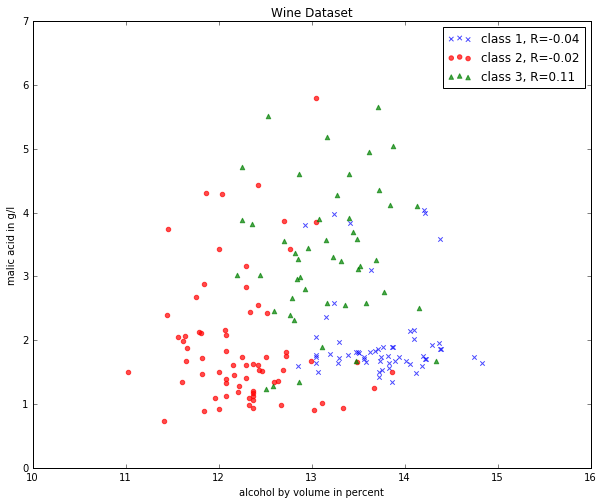

In [4]:
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

plt.figure(figsize=(10,8))

for label,marker,color in zip(
        range(1,4),('x', 'o', '^'),('blue', 'red', 'green')):

    # Calculate Pearson correlation coefficient
    R = pearsonr(X_wine[:,0][y_wine == label], X_wine[:,1][y_wine == label])
    plt.scatter(x=X_wine[:,0][y_wine == label], # x-axis: feat. from col. 1
                y=X_wine[:,1][y_wine == label], # y-axis: feat. from col. 2
                marker=marker, # data point symbol for the scatter plot
                color=color,
                alpha=0.7, 
                label='class {:}, R={:.2f}'.format(label, R[0]) # label for the legend
                )
    
plt.title('Wine Dataset')
plt.xlabel('alcohol by volume in percent')
plt.ylabel('malic acid in g/l')
plt.legend(loc='upper right')

plt.show()

<br>
<br>

If we want to pack 3 different features into one scatter plot at once, we can also do the same thing in 3D:

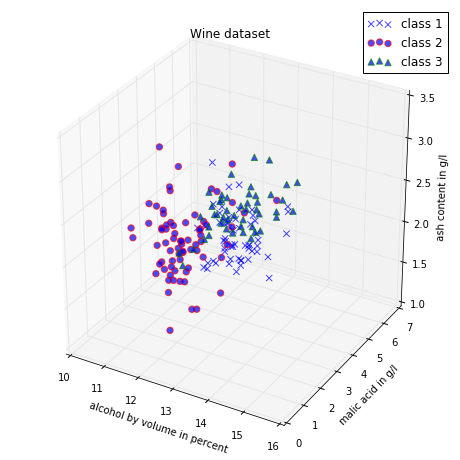

In [5]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
   
for label,marker,color in zip(
        range(1,4),('x', 'o', '^'),('blue','red','green')):
    
    ax.scatter(X_wine[:,0][y_wine == label], 
               X_wine[:,1][y_wine == label], 
               X_wine[:,2][y_wine == label],  
               marker=marker, 
               color=color, 
               s=40, 
               alpha=0.7,
               label='class {}'.format(label))

ax.set_xlabel('alcohol by volume in percent')
ax.set_ylabel('malic acid in g/l')
ax.set_zlabel('ash content in g/l')
plt.legend(loc='upper right')
plt.title('Wine dataset')
     
plt.show()

<br>
<br>

## Splitting into training and test dataset 

[[back to top]](#Sections)

It is a typical procedure for machine learning and pattern classification tasks to split one dataset into two: a training dataset and a test dataset.  
The training dataset is henceforth used to train our algorithms or classifier, and the test dataset is a way to validate the outcome quite objectively before we apply it to "new, real world data".

Here, we will split the dataset randomly so that 70% of the total dataset will become our training dataset, and 30% will become our test dataset, respectively.

In [6]:
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine,
     test_size=0.30, random_state=123)

Note that since this a random assignment, the original relative frequencies for each class label are not maintained.

In [7]:
print('Class label frequencies')
        
print('\nTraining Dataset:')    
for l in range(1,4):
    print('Class {:} samples: {:.2%}'.format(l, list(y_train).count(l)/y_train.shape[0]))
    
print('\nTest Dataset:')     
for l in range(1,4):
    print('Class {:} samples: {:.2%}'.format(l, list(y_test).count(l)/y_test.shape[0]))

Class label frequencies

Training Dataset:
Class 1 samples: 36.29%
Class 2 samples: 42.74%
Class 3 samples: 20.97%

Test Dataset:
Class 1 samples: 25.93%
Class 2 samples: 33.33%
Class 3 samples: 40.74%


<br>
<br>

## Feature Scaling

[[back to top]](#Sections)

Another popular procedure is to standardize the data prior to fitting the model and other analyses so that the features will have the properties of a standard normal distribution with   

$\mu = 0$ and $\sigma = 1$

where $\mu$ is the mean (average) and $\sigma$ is the standard deviation from the mean, so that the standard scores of the samples are calculated as follows:

\begin{equation} z = \frac{x - \mu}{\sigma}\end{equation} 

In [8]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

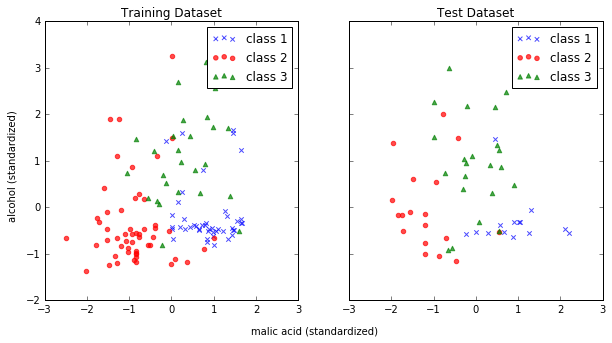

In [9]:
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))

for a,x_dat, y_lab in zip(ax, (X_train, X_test), (y_train, y_test)):

    for label,marker,color in zip(
        range(1,4),('x', 'o', '^'),('blue','red','green')):

        a.scatter(x=x_dat[:,0][y_lab == label], 
                y=x_dat[:,1][y_lab == label], 
                marker=marker, 
                color=color,   
                alpha=0.7,   
                label='class {}'.format(label)
                )

    a.legend(loc='upper right')

ax[0].set_title('Training Dataset')
ax[1].set_title('Test Dataset')
f.text(0.5, 0.04, 'malic acid (standardized)', ha='center', va='center')
f.text(0.08, 0.5, 'alcohol (standardized)', ha='center', va='center', rotation='vertical')

plt.show()

<br>
<br>

<a id="PCA"></a>

<br>
<br>

<a id='MDA'></a>

## Linear Transformation & Classification: Multiple Discriminant Analysis (MDA)

[[back to top]](#Sections)

The main purposes of a Multiple Discriminant Analysis is to analyze the data to identify patterns to project it onto a subspace that yields a better separation of the classes. Also, the dimensionality of the dataset shall be reduced with minimal loss of information.

**The approach is very similar to a Principal Component Analysis (PCA), but in addition to finding the component axes that maximize the variance of our data, we are additionally interested in the axes that maximize the separation of our classes (e.g., in a supervised pattern classification problem)**

Here, our desired outcome of the multiple discriminant analysis is to project a feature space (our dataset consisting of n d-dimensional samples) onto a smaller subspace that represents our data "well" and has a good class separation. A possible application would be a pattern classification task, where we want to reduce the computational costs and the error of parameter estimation by reducing the number of dimensions of our feature space by extracting a subspace that describes our data "best".

#### Principal Component Analysis (PCA) Vs. Multiple Discriminant Analysis (MDA)

Both Multiple Discriminant Analysis (MDA) and Principal Component Analysis (PCA) are linear transformation methods and closely related to each other. In PCA, we are interested to find the directions (components) that maximize the variance in our dataset, where in MDA, we are additionally interested to find the directions that maximize the separation (or discrimination) between different classes (for example, in pattern classification problems where our dataset consists of multiple classes. In contrast two PCA, which ignores the class labels).

**In other words, via PCA, we are projecting the entire set of data (without class labels) onto a different subspace, and in MDA, we are trying to determine a suitable subspace to distinguish between patterns that belong to different classes. Or, roughly speaking in PCA we are trying to find the axes with maximum variances where the data is most spread (within a class, since PCA treats the whole data set as one class), and in MDA we are additionally maximizing the spread between classes.**

In typical pattern recognition problems, a PCA is often followed by an MDA.

![](https://raw.githubusercontent.com/rasbt/pattern_classification/master/Images/mda_overview.png)

If you are interested, you can find more information about the MDA in my IPython notebook   
[Stepping through a Multiple Discriminant Analysis - using Python's NumPy and matplotlib](http://nbviewer.ipython.org/github/rasbt/pattern_classification/blob/master/dimensionality_reduction/projection/linear_discriminant_analysis.ipynb?create=1).

Like we did in the PCA section above, we will use a `scikit-learn` funcion, [`sklearn.lda.LDA`](http://scikit-learn.org/stable/modules/generated/sklearn.lda.LDA.html) in order to transform our training data onto 2 dimensional subspace, where MDA is basically the more generalized form of an LDA (Linear Discriminant Analysis):

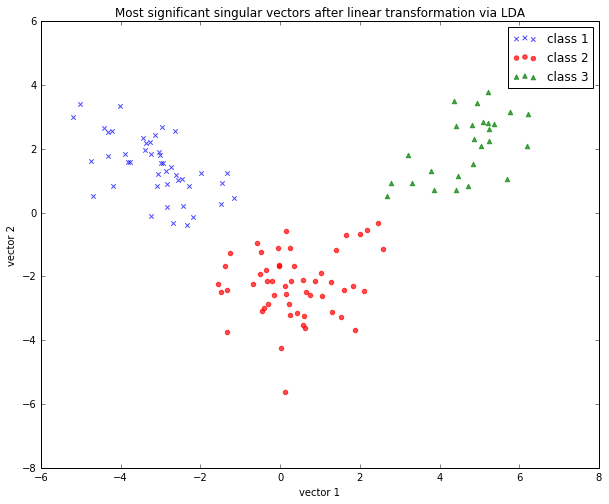

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
sklearn_lda = LDA(n_components=2)
sklearn_transf = sklearn_lda.fit_transform(X_train, y_train)

plt.figure(figsize=(10,8))

for label,marker,color in zip(
        range(1,4),('x', 'o', '^'),('blue', 'red', 'green')):


    plt.scatter(x=sklearn_transf[:,0][y_train == label],
                y=sklearn_transf[:,1][y_train == label], 
                marker=marker, 
                color=color,
                alpha=0.7, 
                label='class {}'.format(label)
                )

plt.xlabel('vector 1')
plt.ylabel('vector 2')

plt.legend()
plt.title('Most significant singular vectors after linear transformation via LDA')

plt.show()

<br>
<br>

<br>
<br>

## Classification via LDA

[[back to top]](#Sections)

The LDA that we've just used in the section above can also be used as a simple linear classifier.

In [12]:
# fit model
lda_clf = LDA()
lda_clf.fit(X_train, y_train)
LDA(n_components=None, priors=None)

# prediction
print('1st sample from test dataset classified as:', lda_clf.predict(X_test[0,:].reshape(1, -1)))
print('actual class label:', y_test[0])

1st sample from test dataset classified as: [3]
actual class label: 3


Another handy subpackage of sklearn is `metrics`. The [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), for example, is quite useful to evaluate how many samples can be classified correctly:

In [13]:
from sklearn import metrics
pred_train = lda_clf.predict(X_train)

print('Prediction accuracy for the training dataset')
print('{:.2%}'.format(metrics.accuracy_score(y_train, pred_train)))

Prediction accuracy for the training dataset
100.00%


To verify that over model was not overfitted to the training dataset, let us evaluate the classifier's accuracy on the test dataset:

In [14]:
pred_test = lda_clf.predict(X_test)

print('Prediction accuracy for the test dataset')
print('{:.2%}'.format(metrics.accuracy_score(y_test, pred_test)))

Prediction accuracy for the test dataset
98.15%


<br>
<br>

**Confusion Matrix**  
As we can see above, there was a very low misclassification rate when we'd apply the classifier on the test data set. A confusion matrix can tell us in more detail which particular classes could not classified correctly.

<table cellspacing="0" border="0">
	<colgroup width="60"></colgroup>
	<colgroup span="4" width="82"></colgroup>
	<tr>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" colspan=2 rowspan=2 height="44" align="center" bgcolor="#FFFFFF"><b><font face="Helvetica" size=4><br></font></b></td>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" colspan=3 align="center" bgcolor="#FFFFFF"><b><font face="Helvetica" size=4>predicted class</font></b></td>
		</tr>
	<tr>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" align="left" bgcolor="#EEEEEE"><font face="Helvetica" size=4>class 1</font></td>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" align="left" bgcolor="#EEEEEE"><font face="Helvetica" size=4>class 2</font></td>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" align="left" bgcolor="#EEEEEE"><font face="Helvetica" size=4>class 3</font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" rowspan=3 height="116" align="center" bgcolor="#F6F6F6"><b><font face="Helvetica" size=4>actual class</font></b></td>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" align="left" bgcolor="#EEEEEE"><font face="Helvetica" size=4>class 1</font></td>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" align="left" bgcolor="#99FFCC"><font face="Helvetica" size=4>True positives</font></td>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" align="left" bgcolor="#F6F6F6"><font face="Helvetica" size=4><br></font></td>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" align="left" bgcolor="#F6F6F6"><font face="Helvetica" size=4><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" align="left" bgcolor="#EEEEEE"><font face="Helvetica" size=4>class 2</font></td>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" align="left" bgcolor="#FFFFFF"><font face="Helvetica" size=4><br></font></td>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" align="left" bgcolor="#99FFCC"><font face="Helvetica" size=4>True positives</font></td>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" align="left" bgcolor="#FFFFFF"><font face="Helvetica" size=4><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" align="left" bgcolor="#EEEEEE"><font face="Helvetica" size=4>class 3</font></td>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" align="left" bgcolor="#F6F6F6"><font face="Helvetica" size=4><br></font></td>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" align="left" bgcolor="#F6F6F6"><font face="Helvetica" size=4><br></font></td>
		<td style="border-top: 1px solid #c1c1c1; border-bottom: 1px solid #c1c1c1; border-left: 1px solid #c1c1c1; border-right: 1px solid #c1c1c1" align="left" bgcolor="#99FFCC"><font face="Helvetica" size=4>True positives</font></td>
	</tr>
</table>

In [15]:
print('Confusion Matrix of the LDA-classifier')
print(metrics.confusion_matrix(y_test, lda_clf.predict(X_test)))

Confusion Matrix of the LDA-classifier
[[14  0  0]
 [ 1 17  0]
 [ 0  0 22]]


As we can see, one sample from class 2 was incorrectly labeled as class 1, from the perspective of class 1, this would be 1 "False Negative" or a "False Postive" from the perspective of class 2, respectively

<br>

<a id='SGD'></a>

## Stochastic Gradient Descent (SGD) as linear classifier

[[back to top]](#Sections)

Let us now compare the classification accuracy of the LDA classifier with a simple classification (we also use the probably not ideal default settings here) via stochastic gradient descent, an algorithm that minimizes a linear objective function.  
More information about the `sklearn.linear_model.SGDClassifier` can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html).

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)

pred_train = sgd_clf.predict(X_train)
pred_test = sgd_clf.predict(X_test)

print('\nPrediction accuracy for the training dataset')
print('{:.2%}\n'.format(metrics.accuracy_score(y_train, pred_train)))

print('Prediction accuracy for the test dataset')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test)))

print('Confusion Matrix of the SGD-classifier')
print(metrics.confusion_matrix(y_test, sgd_clf.predict(X_test)))


Prediction accuracy for the training dataset
100.00%

Prediction accuracy for the test dataset
96.30%

Confusion Matrix of the SGD-classifier
[[14  0  0]
 [ 1 17  0]
 [ 0  1 21]]
